=== CORRELATION ANALYSIS ===

1. Pearson Correlation Matrix
--------------------------------------------------
                           WindSpeed (knots)  AirTemperature (degrees_C)  \
time (UTC)                                                                 
2016-04-29 06:00:00+00:00             20.635                       6.929   
2016-04-29 07:00:00+00:00             19.212                       6.826   
2016-04-29 08:00:00+00:00             19.781                       6.655   
2016-04-29 09:00:00+00:00             20.635                       6.484   
2016-04-29 10:00:00+00:00             18.500                       6.895   

                           AtmosphericPressure (millibars)  \
time (UTC)                                                   
2016-04-29 06:00:00+00:00                         1010.645   
2016-04-29 07:00:00+00:00                         1011.414   
2016-04-29 08:00:00+00:00                         1011.121   
2016-04-29 09:00:00+00:00                     

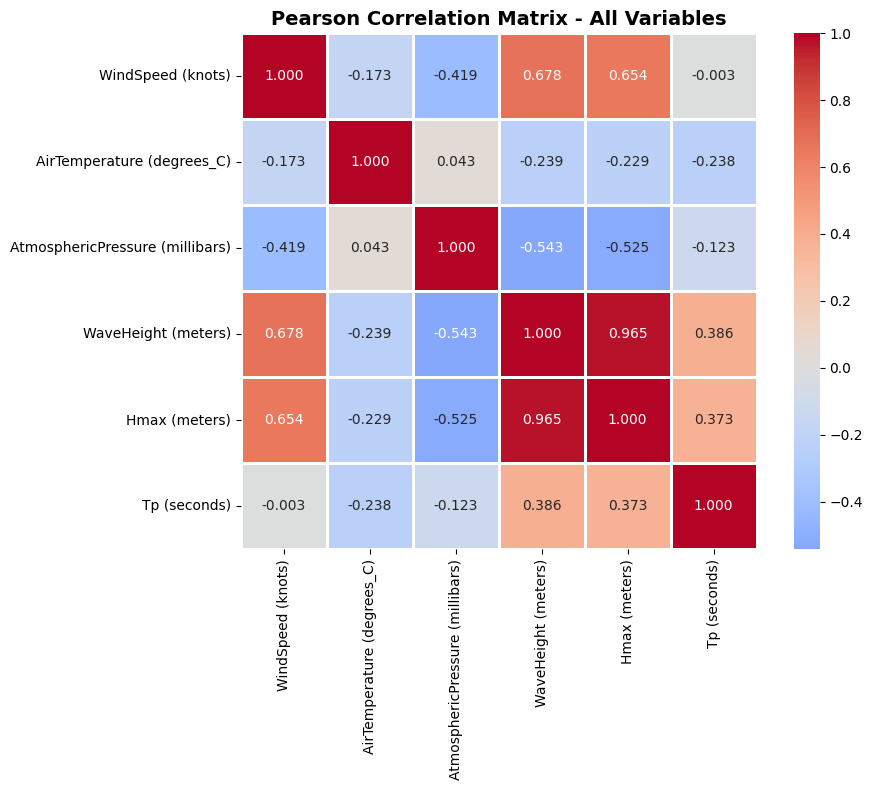


2. Time-Lagged Cross-Correlation Analysis
--------------------------------------------------

Optimal Lag (τ): -4 hours
Maximum Correlation at τ: 0.719
Interpretation: Wind changes LEAD wave formation by 4 hours


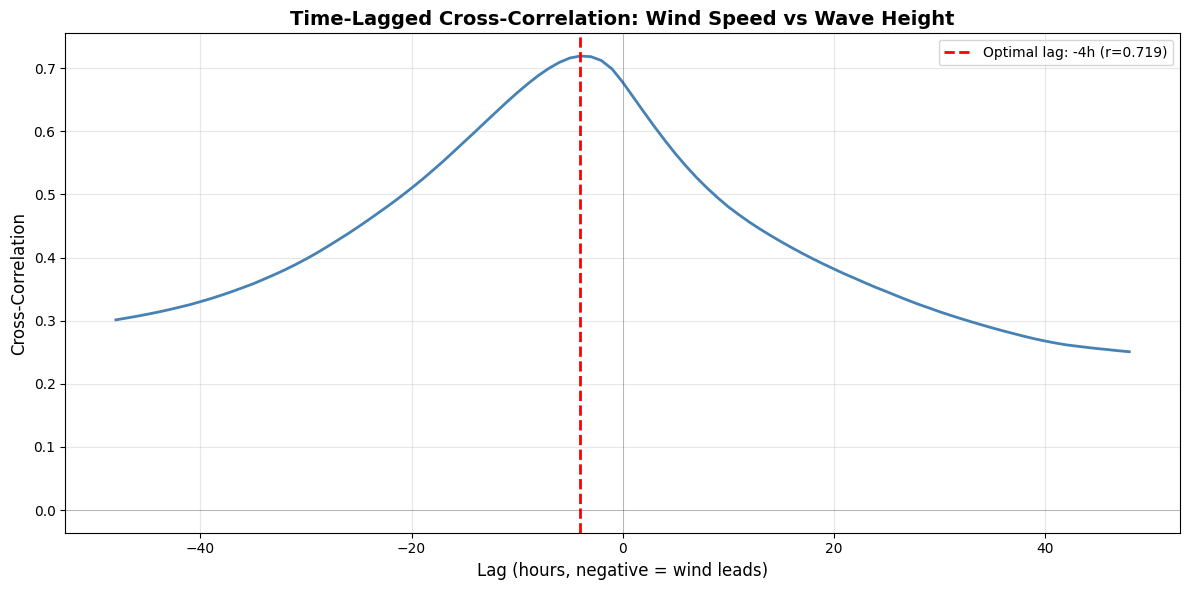


3. All Wave Parameter Correlations with Wind Speed
--------------------------------------------------
WaveHeight (meters)           :  0.678
Hmax (meters)                 :  0.654
Tp (seconds)                  : -0.003


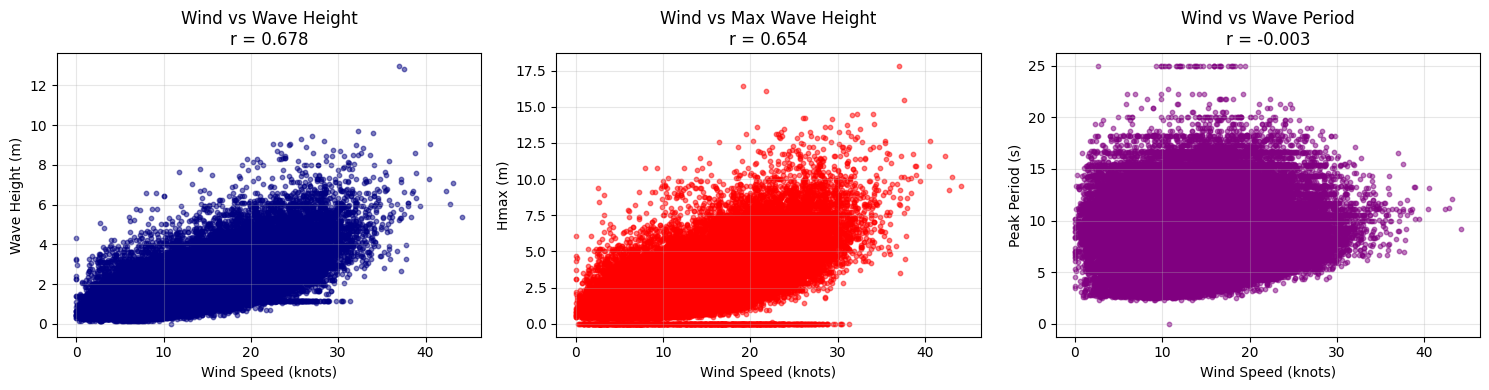


=== SUMMARY ===
✓ Correlation analysis complete
✓ Use lag of -4 hours in your model for temporal alignment


In [1]:
import sys
sys.path.append('../src')
from irish_buoy_data import IrishBuoyData
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Fetch data
buoy = IrishBuoyData(station_id="M5")
data = buoy.fetch_data(days_back=3650)  # Get more data for robust analysis

print("=== CORRELATION ANALYSIS ===\n")

# 1. PEARSON CORRELATION MATRIX
print("1. Pearson Correlation Matrix")
print("-" * 50)

# Select numerical columns (exclude station_id)
numeric_data = data.select_dtypes(include=[np.number])

print(numeric_data.head())

# Calculate correlation matrix
corr_matrix = numeric_data.corr()

# Focus on wind speed correlations
wind_corr = corr_matrix['WindSpeed (knots)'].sort_values(ascending=False)
print("\nCorrelations with Wind Speed:")
print(wind_corr)

# Highlight wave height correlation
wave_wind_corr = corr_matrix.loc['WaveHeight (meters)', 'WindSpeed (knots)']
print(f"\n✓ Wave Height vs Wind Speed Correlation: {wave_wind_corr:.3f}")
print(f"  (Paper reported: ~0.72)")
print(f"  Difference: {abs(wave_wind_corr - 0.72):.3f}")

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Pearson Correlation Matrix - All Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 2. TIME-LAGGED CROSS-CORRELATION (TLCC)
print("\n2. Time-Lagged Cross-Correlation Analysis")
print("-" * 50)

def calculate_tlcc(x, y, max_lag=24):
    """Calculate time-lagged cross-correlation"""
    correlations = []
    lags = range(-max_lag, max_lag + 1)
    
    for lag in lags:
        if lag < 0:
            # Wind leads waves (negative lag)
            corr = np.corrcoef(x[:lag], y[-lag:])[0, 1]
        elif lag > 0:
            # Waves lead wind (positive lag)
            corr = np.corrcoef(x[lag:], y[:-lag])[0, 1]
        else:
            # No lag
            corr = np.corrcoef(x, y)[0, 1]
        correlations.append(corr)
    
    return lags, correlations

# Calculate TLCC for Wind Speed vs Wave Height
wind_speed = data['WindSpeed (knots)'].values
wave_height = data['WaveHeight (meters)'].values

max_lag_hours = 48  # Check up to 48 hours lag
lags, correlations = calculate_tlcc(wind_speed, wave_height, max_lag=max_lag_hours)

# Find optimal lag
optimal_lag_idx = np.argmax(np.abs(correlations))
optimal_lag = lags[optimal_lag_idx]
max_correlation = correlations[optimal_lag_idx]

print(f"\nOptimal Lag (τ): {optimal_lag} hours")
print(f"Maximum Correlation at τ: {max_correlation:.3f}")

if optimal_lag < 0:
    print(f"Interpretation: Wind changes LEAD wave formation by {abs(optimal_lag)} hours")
elif optimal_lag > 0:
    print(f"Interpretation: Wave changes LEAD wind by {optimal_lag} hours (unusual)")
else:
    print("Interpretation: Wind and waves are synchronous (no lag)")

# Plot TLCC
plt.figure(figsize=(12, 6))
plt.plot(lags, correlations, linewidth=2, color='steelblue')
plt.axvline(x=optimal_lag, color='red', linestyle='--', linewidth=2, 
            label=f'Optimal lag: {optimal_lag}h (r={max_correlation:.3f})')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
plt.xlabel('Lag (hours, negative = wind leads)', fontsize=12)
plt.ylabel('Cross-Correlation', fontsize=12)
plt.title('Time-Lagged Cross-Correlation: Wind Speed vs Wave Height', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# 3. ADDITIONAL WAVE CORRELATIONS
print("\n3. All Wave Parameter Correlations with Wind Speed")
print("-" * 50)

wave_params = ['WaveHeight (meters)', 'Hmax (meters)', 'Tp (seconds)']
for param in wave_params:
    corr = corr_matrix.loc[param, 'WindSpeed (knots)']
    print(f"{param:30s}: {corr:6.3f}")

# 4. SCATTER PLOTS
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Wind vs Wave Height
axes[0].scatter(data['WindSpeed (knots)'], data['WaveHeight (meters)'], 
                alpha=0.5, s=10, color='navy')
axes[0].set_xlabel('Wind Speed (knots)')
axes[0].set_ylabel('Wave Height (m)')
axes[0].set_title(f'Wind vs Wave Height\nr = {wave_wind_corr:.3f}')
axes[0].grid(True, alpha=0.3)

# Wind vs Hmax
axes[1].scatter(data['WindSpeed (knots)'], data['Hmax (meters)'], 
                alpha=0.5, s=10, color='red')
axes[1].set_xlabel('Wind Speed (knots)')
axes[1].set_ylabel('Hmax (m)')
corr_hmax = corr_matrix.loc['Hmax (meters)', 'WindSpeed (knots)']
axes[1].set_title(f'Wind vs Max Wave Height\nr = {corr_hmax:.3f}')
axes[1].grid(True, alpha=0.3)

# Wind vs Wave Period
axes[2].scatter(data['WindSpeed (knots)'], data['Tp (seconds)'], 
                alpha=0.5, s=10, color='purple')
axes[2].set_xlabel('Wind Speed (knots)')
axes[2].set_ylabel('Peak Period (s)')
corr_tp = corr_matrix.loc['Tp (seconds)', 'WindSpeed (knots)']
axes[2].set_title(f'Wind vs Wave Period\nr = {corr_tp:.3f}')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== SUMMARY ===")
print(f"✓ Correlation analysis complete")
print(f"✓ Use lag of {optimal_lag} hours in your model for temporal alignment")